In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [3]:
BATCH_SIZE = 32
EPOCHS = 30
learning_rate = 1e-4
IMG_SIZE = (224, 224)

In [4]:
data = np.load('./processed-data/data.npy')
labels = np.load('./processed-data/labels.npy')

In [5]:
(train_data, test_data, train_label, test_label) = train_test_split(data, labels, test_size=0.1)

In [6]:
(train_data, validation_data, train_label, validation_label) = train_test_split(train_data, train_label, test_size=0.2)

In [7]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [14]:
IMG_SHAPE = IMG_SIZE + (3, )

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SHAPE)
print(base_model.summary())
base_model.trainable = False

0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 14, 14, 256)  131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]      

In [9]:
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(256, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

In [10]:
model = Model(inputs=base_model.input, outputs=head_model)

In [13]:
model.compile(optimizer=Adam(lr=learning_rate, decay=learning_rate / EPOCHS), loss="binary_crossentropy", metrics=["accuracy"])

In [17]:
fitted_model = model.fit(
                        aug.flow(train_data, train_label, batch_size=BATCH_SIZE),
                        steps_per_epoch=len(train_data) // BATCH_SIZE,
                        validation_data=(validation_data, validation_label),
                        epochs=EPOCHS)

Epoch 1/30
147/147 [==============================] - 190s 1s/step - loss: 0.3115 - accuracy: 0.8655 - val_loss: 0.1387 - val_accuracy: 0.9501
Epoch 2/30
147/147 [==============================] - 89s 602ms/step - loss: 0.1580 - accuracy: 0.9432 - val_loss: 0.1102 - val_accuracy: 0.9586
Epoch 3/30
147/147 [==============================] - 87s 590ms/step - loss: 0.1261 - accuracy: 0.9536 - val_loss: 0.0953 - val_accuracy: 0.9662
Epoch 4/30
147/147 [==============================] - 87s 592ms/step - loss: 0.1052 - accuracy: 0.9604 - val_loss: 0.0967 - val_accuracy: 0.9679
Epoch 5/30
147/147 [==============================] - 95s 643ms/step - loss: 0.1057 - accuracy: 0.9598 - val_loss: 0.0844 - val_accuracy: 0.9721
Epoch 6/30
147/147 [==============================] - 88s 598ms/step - loss: 0.0938 - accuracy: 0.9642 - val_loss: 0.0879 - val_accuracy: 0.9704
Epoch 7/30
147/147 [==============================] - 91s 617ms/step - loss: 0.0879 - accuracy: 0.9645 - val_loss: 0.0790 - val_accu

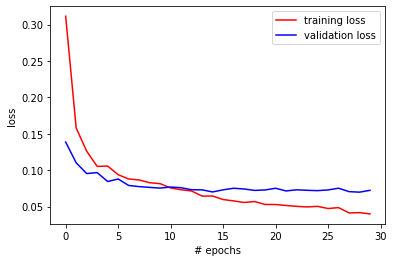

In [18]:
plt.plot(fitted_model.history['loss'], 'r', label='training loss')
plt.plot(fitted_model.history['val_loss'], 'b', label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig("plots/loss-plot.png")
plt.show()

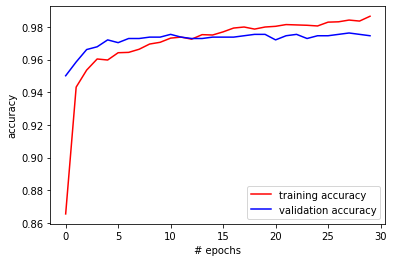

In [19]:
plt.plot(fitted_model.history['accuracy'],'r',label='training accuracy')
plt.plot(fitted_model.history['val_accuracy'], 'b', label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig("plots/accuracy-plot.png")
plt.show()

In [22]:
print(model.evaluate(test_data, test_label))

21/21 [==============================] - 8s 369ms/step - loss: 0.0822 - accuracy: 0.9756
[0.08224798738956451, 0.9756468534469604]


In [24]:
model.save('face-mask-detector.h5')